# Práctica 4 - Deep Learning en Imagen Médica

Grupo 14:
- Mario Campos Vicente
- Adrián Sequera Robledo
- Gonzalo Lardiés Guillén


En primer lugar importamos los módulos necesarios para realizar la práctica:

In [4]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import os

In [5]:
import matplotlib.pyplot as plt
import statistics as stats
import pandas as pd
import scipy.stats
import numpy as np
from skimage import io, exposure #Para los histogramas de las imágenes

In [0]:
# Importamos los módulos necesarios para redes convolucionales
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle                                                       
import tensorflow as tf                
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras

## 1. Carga de imágenes y análisis de histogramas

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

* Cargamos la base de datos

In [0]:
data = pd.read_csv("/content/drive/MyDrive/Práctica4_AIM/labels.csv")
data.hist(figsize=(12, 9), bins=70, xlabelsize=8, ylabelsize=8);

* Hemos importado los archivos de imagen y labels. A continuación hemos representado el histograma de las 3 primeras imágenes.

In [7]:
#Vemos que es una base de datos balanceada donde tenemos el mismo número de etiquetas para cada clase
plt.hist(data['hemorrhage'], bins=70, label='Hemorragia')

NameError: name 'data' is not defined

In [8]:
print(data["hemorrhage"])

NameError: name 'data' is not defined

* Cargamos las imágenes

In [1]:
import cv2

# Función para cargar todas las imágenes en una lista
def load_images_from_folder(folder):
    images = []
    lista_rutas = [os.path.join(folder,str(i).zfill(3)+'.png') for i in range(0,200)]
    for filename in lista_rutas:
      img = cv2.imread(filename, 0)
      if img is not None:
        images.append(img)
    return images

In [2]:
array_imagenes = load_images_from_folder(folder='/content/drive/MyDrive/Práctica4_AIM/head_ct')

NameError: name 'os' is not defined

In [3]:
# Imprimimos una de las imágenes para ver si está correctamente realizado el proceso
plt.imshow(array_imagenes[2])

NameError: name 'plt' is not defined

In [0]:
print('El tamaño de la imagen 2 es:',array_imagenes[2].shape,'. Su máximo valor de gris es:',np.max(array_imagenes[2]))
print('El tamaño de la imagen 2 es:',array_imagenes[10].shape,'. Su máximo valor de gris es:',np.max(array_imagenes[10]))

El tamaño de la imagen 2 es: (725, 662, 3) . Su máximo valor de gris es: 255
El tamaño de la imagen 2 es: (285, 247, 3) . Su máximo valor de gris es: 253


255


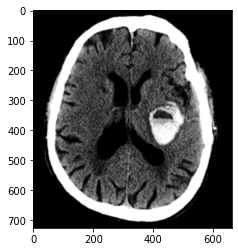

In [0]:
# Como se puede apreciar es multicanal
plt.imshow(array_imagenes[2][0:725,0:662,0],cmap='gray')
print(np.max(array_imagenes[2][0:725,0:662,2]))

In [0]:
imagen1, imagen2, imagen3 = array_imagenes[10][0:725,0:662,0], array_imagenes[10][0:725,0:662,1], array_imagenes[10][0:725,0:662,2]
comparacion = imagen1==imagen3
comparacion2 = comparacion.all()
print(comparacion2)

True


Text(0.5, 1.0, 'Histograma tercera imagen')

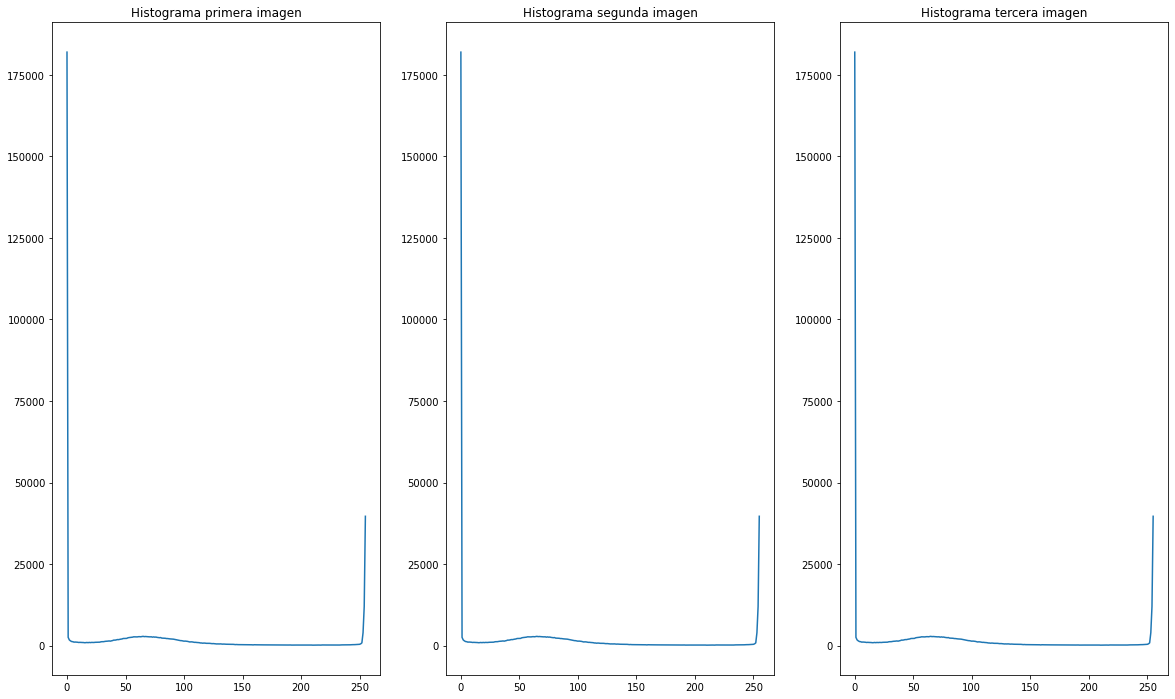

In [0]:
counts, bins = exposure.histogram(array_imagenes[2][0:725,0:662,0])
counts2, bins2 = exposure.histogram(array_imagenes[2][0:725,0:662,1])
counts3, bins3 = exposure.histogram(array_imagenes[2][0:725,0:662,2])


fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(bins,counts)
ax1.set_title('Histograma primera imagen')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(bins2,counts2)
ax2.set_title('Histograma segunda imagen')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(bins3,counts3)
ax3.set_title('Histograma tercera imagen')

Con estos dos ejemplos podemos ver que las imágenes tienen tamaños diferentes así como también dimensiones distintas por lo que será necesario normalizar el tamaño y la escala de grises. 

## 2. Preprocesado

En este apartado se llevará a cabo la normalización de las imágenes tanto en tamaño (donde se asignará el tamaño medio de todas a cada imagen de manera que no se pierda mucha resolución en algunas) como en niveles de gris (teniendo los valores de gris en un rango entre cero y uno).

In [0]:
#Obtenemos los valores de dimensiones máximos y calculamos datos como el valor medio para hacer el resize de las imágenes
shape0 = []
shape1 = []

for i in range(0,len(array_imagenes)):
    imagen = array_imagenes[i]
    shape0.append(imagen.shape[0])
    shape1.append(imagen.shape[1])
    
print(len(shape0),len(shape1))
print(max(shape0),max(shape1)) #Ambos tamaños son de la primera imagen
print(shape0,shape1)

#Hallamos la media para las dimensiones
media_filas = int(np.mean(shape0))
media_columnas = int(np.mean(shape1))
print(media_filas,media_columnas)

200 200
957 821
[957, 768, 725, 708, 690, 690, 497, 500, 498, 288, 285, 635, 559, 601, 612, 495, 491, 623, 589, 582, 437, 608, 505, 301, 518, 604, 605, 564, 648, 623, 564, 413, 423, 624, 597, 615, 548, 652, 543, 591, 597, 358, 350, 509, 493, 528, 454, 459, 591, 559, 466, 415, 508, 520, 396, 410, 407, 555, 558, 238, 232, 632, 621, 649, 627, 290, 281, 405, 386, 554, 518, 582, 627, 577, 554, 338, 378, 293, 300, 367, 372, 641, 599, 456, 609, 410, 404, 353, 352, 337, 272, 467, 454, 443, 622, 576, 304, 576, 573, 544, 511, 504, 336, 422, 290, 283, 399, 408, 416, 315, 317, 317, 504, 435, 265, 269, 294, 296, 299, 287, 281, 287, 290, 290, 267, 271, 298, 291, 284, 468, 451, 454, 450, 513, 520, 530, 512, 521, 509, 464, 461, 462, 426, 424, 409, 301, 295, 293, 308, 292, 299, 241, 232, 276, 263, 268, 267, 265, 278, 270, 252, 251, 437, 436, 441, 465, 464, 457, 460, 456, 452, 430, 422, 414, 400, 361, 348, 326, 582, 591, 622, 392, 630, 629, 323, 325, 305, 308, 251, 251, 251, 225, 158, 225, 227, 223, 199

255.0


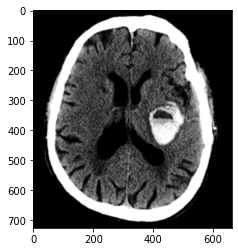

In [0]:
#Transformamos la imagen escala de gris sin que sea multicanal para saber que se puede aplicar a todas las imágenes
imagen_monocanal = np.mean(array_imagenes[2], axis=2)
print(np.max(imagen_monocanal))
plt.imshow(imagen_monocanal,cmap='gray')

Text(0.5, 1.0, 'Histograma imagen original')

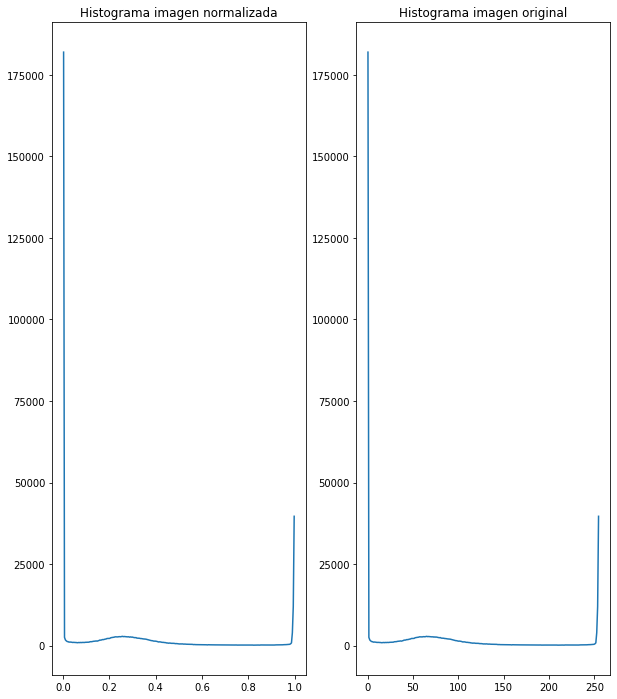

In [0]:
#Podemos ver de esta manera que hemos realizado la normalización de esta imagen correcta ya que los histogramas son iguales
imagen_normalizada = imagen_monocanal/np.max(imagen_monocanal)
counts, bins = exposure.histogram(imagen_normalizada)
counts2, bins2 = exposure.histogram(imagen_monocanal)


fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(bins,counts)
ax1.set_title('Histograma imagen normalizada')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(bins2,counts2)
ax2.set_title('Histograma imagen original')

In [0]:
#En esta celda se producirá la normalización tanto de valores de gris como de tamaño

from skimage.transform import resize

imagenes_pre = []

for i in range(0,len(array_imagenes)):
    imagen = array_imagenes[i]
    imagen_monocanal = np.mean(imagen, axis=2)
    imagen_resize = resize(imagen_monocanal, (media_filas, media_columnas))
    imagen_normalizada = imagen_resize/np.max(imagen_resize)
    imagenes_pre.append(imagen_normalizada)
    if type(array_imagenes[i]) == "uint8":
        imagen_normalizada = imagen_resize/255
    elif type(array_imagenes[i]) == "uint8":
        imagen_normalizada = imagen_resize/65535
    else:
        print(type())
print(len(imagenes_pre))


200


In [0]:
Normalizamos el tamaño de las imagenes al tamaño medio de todas ellas y normalizamos los valores de 

(433, 355) (433, 355)


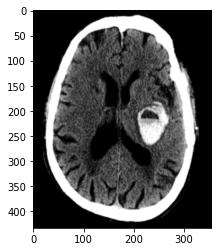

In [0]:
plt.imshow(imagenes_pre[2],cmap='gray')
print(imagenes_pre[2].shape,imagenes_pre[120].shape) #Podemos ver que las hemos dejado todas iguales

## 3. Diseño de la red convolucional / 4. Entrenamiento y evaluación de la red

In [0]:
#Ponemos la lista de imágenes como array y las ponemos en el input
images = np.array(imagenes_pre)
etiquetas = data['hemorrhage']

In [0]:
train_images, test_images, train_labels, test_labels = train_test_split(images,etiquetas,test_size = 0.2,random_state = 20)

In [0]:
#Creamos la red neuronal ( de momento ésta funciona y la anterior no)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(433, 355)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [0]:
#Compilamos
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
5/5 [==============================] - 1s 126ms/step - loss: 63.5130 - accuracy: 0.4962
Epoch 2/10
5/5 [==============================] - 1s 124ms/step - loss: 55.5880 - accuracy: 0.4909
Epoch 3/10
5/5 [==============================] - 1s 122ms/step - loss: 33.0398 - accuracy: 0.5472
Epoch 4/10
5/5 [==============================] - 1s 122ms/step - loss: 12.4303 - accuracy: 0.5339
Epoch 5/10
5/5 [==============================] - 1s 118ms/step - loss: 7.1206 - accuracy: 0.5865
Epoch 6/10
5/5 [==============================] - 1s 118ms/step - loss: 8.3526 - accuracy: 0.5453
Epoch 7/10
5/5 [==============================] - 1s 115ms/step - loss: 4.3978 - accuracy: 0.6523
Epoch 8/10
5/5 [==============================] - 1s 121ms/step - loss: 2.7826 - accuracy: 0.7567
Epoch 9/10
5/5 [==============================] - 1s 123ms/step - loss: 2.9273 - accuracy: 0.6825
Epoch 10/10
5/5 [==============================] - 1s 116ms/step - loss: 3.1764 - accuracy: 0.7586


In [0]:
#Evaluamos en test
model.evaluate(test_images, test_labels)

2/2 [==============================] - 0s 16ms/step - loss: 2.0018 - accuracy: 0.8000


[2.001786231994629, 0.800000011920929]

In [0]:
##############################################

In [0]:
#Creamos la red neuronal de conv y pooling 
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu',input_shape = (433, 355,1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])



In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Antes de introducir el fit , hay que hacer un reshape a train para que sea de 4 dimensiones, es lo que piden las neuronas
train_imagenes = train_images.reshape(-1, 433, 355, 1)
model.fit(train_imagenes, train_labels, batch_size=10, epochs=5, validation_split = 0.2)

Epoch 1/5
13/13 [==============================] - 22s 2s/step - loss: 6.3450 - accuracy: 0.5374 - val_loss: 1.1163 - val_accuracy: 0.5000
Epoch 2/5
13/13 [==============================] - 20s 2s/step - loss: 0.6043 - accuracy: 0.7204 - val_loss: 0.6662 - val_accuracy: 0.5625
Epoch 3/5
13/13 [==============================] - 20s 2s/step - loss: 0.4465 - accuracy: 0.8022 - val_loss: 0.6193 - val_accuracy: 0.7188
Epoch 4/5
13/13 [==============================] - 20s 2s/step - loss: 0.2574 - accuracy: 0.9406 - val_loss: 0.5955 - val_accuracy: 0.6875
Epoch 5/5
13/13 [==============================] - 20s 2s/step - loss: 0.1705 - accuracy: 0.9301 - val_loss: 0.5773 - val_accuracy: 0.7812


In [0]:
#Evaluamos en test
test_imagenes = test_images.reshape(-1, 433, 355, 1)
model.evaluate(test_imagenes, test_labels)

2/2 [==============================] - 2s 287ms/step - loss: 0.5947 - accuracy: 0.7500


[0.594650149345398, 0.75]

In [0]:
type(train_images)

numpy.ndarray

In [0]:
train_images.shape

(160, 433, 355)

In [0]:
train_labels.shape

(160,)

In [0]:
train_imagenes = train_images.reshape(160,433,355,1)

In [0]:
print(train_imagenes.shape)

(160, 433, 355, 1)


In [0]:
###############################################################

In [0]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [0]:
model = Sequential()
model.add(Conv2D(input_shape= (433, 355,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Antes de introducir el fit , hay que hacer un reshape a train para que sea de 4 dimensiones, es lo que piden las neuronas
train_imagenes = train_images.reshape(-1, 433, 355, 1)
model.fit(train_imagenes, train_labels, batch_size=10, epochs=5, validation_split = 0.2)

Epoch 1/5
13/13 [==============================] - 754s 58s/step - loss: 0.9745 - accuracy: 0.3554 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 2/5
13/13 [==============================] - 744s 57s/step - loss: 0.6974 - accuracy: 0.4762 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 3/5
13/13 [==============================] - 745s 58s/step - loss: 0.6903 - accuracy: 0.5666 - val_loss: 0.6914 - val_accuracy: 0.5312
Epoch 4/5
13/13 [==============================] - 742s 57s/step - loss: 0.6919 - accuracy: 0.5366 - val_loss: 0.6912 - val_accuracy: 0.5312
Epoch 5/5
13/13 [==============================] - 741s 57s/step - loss: 0.6954 - accuracy: 0.5030 - val_loss: 0.6912 - val_accuracy: 0.5312


In [0]:
#Evaluamos en test
test_imagenes = test_images.reshape(-1, 433, 355, 1)
model.evaluate(test_imagenes, test_labels)

2/2 [==============================] - 59s 12s/step - loss: 0.7137 - accuracy: 0.3500


[0.7137166857719421, 0.3499999940395355]